# Wykrywanie słów kluczowych

Niniejszy zeszyt zawiera potok metody przetwarzania krótkich tekstów w celu detekcji słów kluczowych, przygotowanej dla projektu WykOp TrEnds Detector (WOnTED-project).

### *Kontekst*

Pierwotnie, *słowo kluczowe* to słowo, które pojawia się w tekście częściej, niż wówczas, gdyby pojawiało się ono losowo. Definicja ta nie stosuje się jednak w przypadku krótkich tekstów, gdzie każde ze słów pojawia się maksymalnie kilkukrotnie, dlatego też konieczne jest sformułowanie bardziej poprawnej definicji słowa kluczowego. W zastosowanym poniżej podejściu, słowo kluczowe wyraża główny temat danego tekstu, najbardziej istotną informację jaką on zawiera, czy też problem, który omawia.

## Przedstawienie proponowanej metody

Główną cechą prezentowanej metody jest wykorzystanie grafu relacji, zbudowanego na podstawie listy lematów i następnie rozbudowywanego z użyciem Słowosieci i innych technik.

#### Analiza morfo-syntaktyczna, wykrywanie nazw własnych

1. Pierwszym etapem jest analiza morfo-syntaktyczna, przeprowadzana w celu ekstrakcji lemat każdego ze słów oraz ich tagu części mowy. Wykorzystywanym narzędziem jest analizator morfo-syntaktyczny WCRFT2, dostępny z użyciem API *nlprest2*. Dostarcza ono również innych narzędzi, spośród których wykorzystywany jest Liner2 (do detekcji nazw własnych).

2. WCRFT2 wykorzystuje własny format pliku (*CCL*), który musi być zdekodowany do dalszego przetwarzania. W tym celu wykorzystany został obraz Dockera dostarczany przez CLARIN-PL. W obrazie tym znajdują się biblioteki w języku python, pozwalające na ekstrakcję lematów, tagów części mowy oraz nazw własnych, wykorzystując wcześniej wygenerowane pliki.

#### Wstępne przetwarzanie tekstu

3. Dalsze kroki przetwarzania to przede wszystkim oczyszczanie danych. Skoncentrowane jest ono na oczyszczaniu zbioru tekstów, tj. usuwanie spójników i interpunkcji oraz ustalenie minimalnej długości lematu, odrzucając te, które są za krótkie. Również nazwy własne są przetwarzane - przeprowadzana jest ich lematyzacja. W przypadku etykietowanego zbioru, słowa kluczowe są również lematyzowane.

#### Konstrukcja grafu

4. Wykorzystując wygenerowaną listę lematów, poprzez łączenie każdego z nich ze swoimi sąsiadami tworzony jest graf.


5. Graf ten jest rozbudowywany wykorzystując kilka metod: łączenie wyrazów tworzących wielowyrazowe nazwy własne, łączenie wyrazów poprzez obliczanie podobieństwa ich wektorów zagłębień (podobieństwo cosinusowe) - z wykorzystaniem pretrenowanego modelu FastText dostarczonego przez CLARIN-PL, oraz rozbudowywanie grafu przez pobieranie relacji ze Słowosieci dla każdego lematu (dodawanie nowych węzłów połączonych z każdym lematem, reprezentującym inny lemat, który łączy się przez określoną relację semantyczną, a następnie rozbudowywanie o kolejną warstwę, tj. dostarczanie węzłów połączonych kolejnymi relacjami z uprzednio utworzonymi węzłami).

#### Utworzenie zbioru danych

6. Do wytrenowania modelu w sposób nadzorowany konieczne jest utworzenie zbioru danych na podstawie cech poprawnie reprezentujących rzeczywiste relacje w tekście. W niniejszej metodzie zastosowano kilka metod tworzenia cech. Przede wszystkich, używając wygnerowanego w poprzednim kroku grafu obliczane są metryki dla węzłów lematów (PageRank centrality, betweenness centrality oraz stopień węzła). Kolejną cechą są tagi części mowy - dla rzeczowników, czasowników i przymiotników. Kolejnym wykorzystywanym elementem są nazwy własne - każdy lemat jest klasyfikowany pod względem tego, czy jest słowem kluczowym albo czy należy do wielowyrazowego słowa kluczowego. Ostatnie cechy określane są z użyciem metody TF-IDF (korpus dla metody IDF konstruowany jest z użyciem całego zbioru treningowego i walidacyjnego, używając zlematyzowanych dokumentów).

#### Trenowanie modelu i jego ewaluacja

7. Detekcja słów kluczowych przeprowadzana jest z użyciem jednego z trzech modeli regresji: SVR (Support Vector Regression), Random Forest Regressor i sieci neuronowej LSTM. Modele te zostały wytrenowane na wspomnianym wcześniej zbiorze danych i dokonują one predykcji prawdopodobieństwa, że dane słowo jest słowem kluczowym (dla każdego ze słów w dokumencie).


8. Modele są ewaluowane przez wyodrębnienie ze zbioru treningowego zbioru testowego i obliczanie miar poprawności działania modelu (dokładność, kompletność, f-score) na tym zbiorze, przy trenowaniu na reszcie zbioru treningowego.

#### Predykcja

9. Aby uzyskać listę słów kluczowych wykonywane jest progowanie prawdopodobieństwa. Opiera się ono na obliczaniu średniego prawdopodobieństwa oraz jego odchylenia standardowego. Każde słowo, którego prawdopodobieństwo, że jest ono słowem kluczowym jest większe lub równe sumie średniego prawdopodobieństwa i połowy odchylenia standardowego jest proponowane jako słowo kluczowe.

## Ten zeszyt

Zeszyt zawiera pełen potok przetwarzania w celu detekcji słów kluczowych w tekstach zawartych w zbiorze treningowym lub walidacyjnym, jak również w dodatkowo wprowadzanych tekstach. Aby użyć metody należy zastosować się do instrukcji i komentarzy zawartych w komórkach.

---

In [1]:
from ipywidgets import interactive


---
### Wybór głębokości przeszukiwania Słowosieci

Wartość ta jest później przekazywana do funkcji rozbudowy grafu - dostępne wartości to 0 (brak wykorzystania grafu), 1 (jeden poziom relacji dla każdego lematu) oraz 2 (dwa poziomy relacji - relacje dla słów w relacji z lematem).

In [2]:
def get_wordnet_depth(depth):
        return depth
    
print('Ustaw głębokość przeszukiwania Słowosieci:')
widget_depth = interactive(get_wordnet_depth, depth=[0, 1, 2])
display(widget_depth)


Ustaw głębokość przeszukiwania Słowosieci:


interactive(children=(Dropdown(description='depth', options=(0, 1, 2), value=0), Output()), _dom_classes=('wid…

---
### Wybór źródła analizowanych danych

W zeszycie umożliwiony został odczyt dowolnego dokumentu ze zbioru uczącego oraz wprowadzenie własnego tekstu w celu jego analizy.

In [3]:
from wonted_dataset import WontedDataset


In [4]:
wd = WontedDataset(graph_depth=widget_depth.result)

def get_mode(mode):    
    if mode == 'train dataset':
        wd.load_data(filename=f'wonted_{widget_depth.result}.json')
        print(f'Załadowano wonted_{widget_depth.result}.json. \n'
              'Zbiór treningowy (KPWr)')
        return mode
    elif mode == 'validation dataset':
        wd.load_data(filename=f'wonted_{widget_depth.result}.json')
        print(f'Załadowano wonted_{widget_depth.result}.json. \n'
              'Zbiór walidacyjny (Wykop)')
        return mode
    elif mode == 'custom':
        print('Podaj analizowany tekst w następnej komórce.')
        return mode

print('Wybierz źródło danych:')
widget_mode = interactive(get_mode, mode=['custom', 'train dataset', 'validation dataset'])
display(widget_mode)


Wybierz źródło danych:


interactive(children=(Dropdown(description='mode', options=('custom', 'train dataset', 'validation dataset'), …

#### Własny tekst

W przypadku własnego tekstu wystarczy wprowadzić go w formularzu poniżej.

In [5]:
def get_custom_text(text):
    if widget_mode.result != 'custom':
        print('Nie wybrano odpowiedniego trybu!')
    return text, 'custom'

print('Podaj swój tekst')
widget_text = interactive(get_custom_text, text='Twój tekst')
display(widget_text)


Podaj swój tekst


interactive(children=(Text(value='Twój tekst', description='text'), Output()), _dom_classes=('widget-interact'…

#### Tekst ze zbioru KPWr

Dla zbioru treningowego należy wybrać kategorię źródłową oraz dokument z kategorii. Dodatkowo, ze względu na dostępne etykiety, wyświetlana jest lista słów kluczowych.

In [6]:
def get_kpwr_text(dataset):
    if widget_mode.result != 'train dataset':
        print('Nie wybrano odpowiedniego trybu!')
    return dataset

print('Wybierz źródło tekstu')
widget_kpwr_dataset = interactive(get_kpwr_text, dataset=sorted(list(wd.train_datasets.keys())))
display(widget_kpwr_dataset)


Wybierz źródło tekstu


interactive(children=(Dropdown(description='dataset', options=('processed_dataset/dataset_blogi.csv', 'process…

In [7]:
def get_kpwr_row(row):
    text = wd.train_datasets[widget_kpwr_dataset.result].records[row].text
    keywords = wd.train_datasets[widget_kpwr_dataset.result].records[row].keywords
    filename = wd.train_datasets[widget_kpwr_dataset.result].records[row].filename
    print(text)
    print(f'\n\n  Słowa kluczowe: {keywords}')
    return text, filename

print('Wybierz dokument')
widget_kpwr_row = interactive(get_kpwr_row, row=range(len(wd.train_datasets[widget_kpwr_dataset.result].records)))
display(widget_kpwr_row)


Wybierz dokument


interactive(children=(Dropdown(description='row', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

#### Tekst ze zbioru Wykop.pl

Dla zbioru walidacyjnego etykiety nie były dostępne, w związku z tym możliwy jest jedynie wybór jednego ze zgromadzonych dokumentów oraz jego wyświetlenie.

In [8]:
def get_wykop_text(dataset):
    if widget_mode.result != 'validation dataset':
        print('Nie wybrano odpowiedniego trybu!')
    return dataset

print('Wybierz źródło tekstu')
widget_wykop_dataset = interactive(get_wykop_text, dataset=sorted(list(wd.val_datasets.keys())))
display(widget_wykop_dataset)


Wybierz źródło tekstu


interactive(children=(Dropdown(description='dataset', options=('processed_dataset/dataset_wykop.csv',), value=…

In [9]:
def get_wykop_row(row):
    text = wd.val_datasets[widget_wykop_dataset.result].records[row].text
    filename = wd.val_datasets[widget_wykop_dataset.result].records[row].filename
    print(text)
    return text, filename

print('Wybierz dokument')
widget_wykop_row = interactive(get_wykop_row, row=range(len(wd.val_datasets[widget_wykop_dataset.result].records)))
display(widget_wykop_row)


Wybierz dokument


interactive(children=(Dropdown(description='row', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

---
## Proces przetwarzania tekstu

Kolejne komórki w zeszycie zawierają funkcje niezbędne do przeprowadzenia detekcji słów kluczowych. Potok ten wykonywany jest dla każdej predykcji.

In [10]:
if widget_mode.result == 'train dataset':
    text, filename = widget_kpwr_row.result
elif widget_mode.result == 'validation dataset':
    text, filename = widget_wykop_row.result
else:
    text, filename = widget_text.result
text


'Litwo, Ojczyzno moja! ty jesteś jak zdrowie; Ile cię trzeba cenić, ten tylko się dowie, Kto cię stracił. Dziś piękność twą w całej ozdobie Widzę i opisuję, bo tęsknię po tobie.'

### Analiza morfo-syntaktyczna i wstępne przetwarzanie tekstu

In [11]:
from preprocess import fetch_single_text

fetch_single_text(text)
print('Zapisano plik temp_0.xml dla wybranego tekstu')


Fetching temp_0
Zapisano plik temp_0.xml dla wybranego tekstu


In [12]:
from xml_dataset import XMLDataset

ds = XMLDataset(docker=True, source_dir = './', load=False, keywords=False, extension='temp_0.xml')
ds.generate_records()
print('Wygenerowano dane po analizie.')


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

Wygenerowano dane po analizie.


### Konstrukcja grafu

In [13]:
from graph import GraphBuilder, vizualize_graph

builder = GraphBuilder(ds.records[0], depth=widget_depth.result)
builder.build()
print('Zbudowano graf.')


0it [00:00, ?it/s]
100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:07<00:00,  2.46s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  3.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Zbudowano graf.


Możliwa jest wizualizacja zbudowanego grafu, pozwalająca na udowodnienie pojawienia się oczekiwanych połączeń pomiędzy niektórymi węzłami dodanymi w procesie rozbudowy grafu.

/home/piotrz/TensorFlowGPU/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


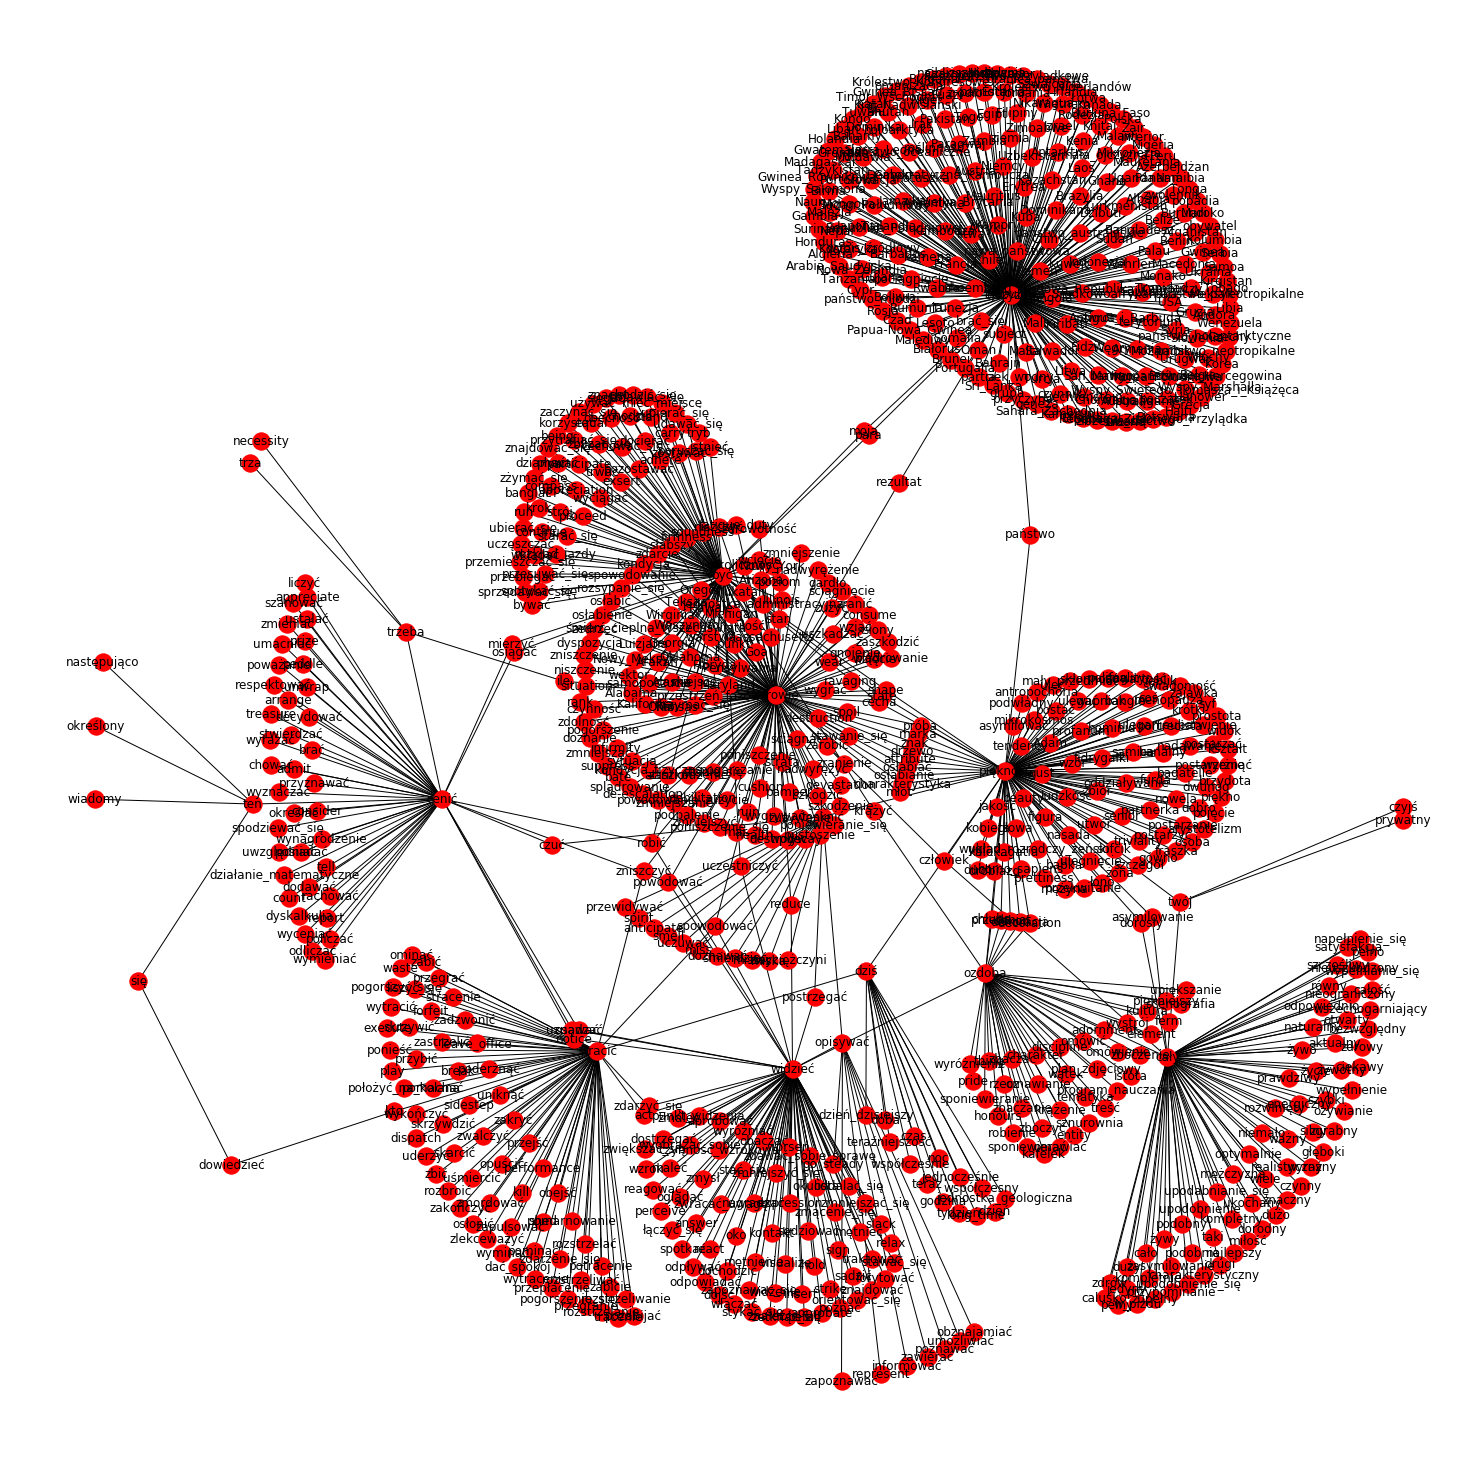

In [14]:
g = builder.graph
vizualize_graph(g, figsize=(20, 20), scale=10)


### Utworzenie zbioru danych

In [15]:
from wonted_dataset import WontedDataset


In [16]:
est_dataset = WontedDataset(use_network=True, use_pos=True, use_proper=True, use_tfidf=True, graph_builder=builder)
X = est_dataset.get_custom(ds.records[0])


In [17]:
import pandas as pd
pd.DataFrame(X, columns=['lemma', 'PageRank', 'betweenness', 'degree', 'noun', 'verb', 'adj', 'single_proper', 'multi_proper', 'tf', 'idf', 'tfidf'])


lemma     PageRank  betweenness degree noun verb adj single_proper  \
0        litwa  0.000632212            0      1    1    0   0             1   
1     ojczyzna    0.0644744      0.23873    239    1    0   0             0   
2         moja  0.000992135     0.053896      2    1    0   0             0   
3          być    0.0440752     0.220352    104    0    1   0             0   
4      zdrowie    0.0614343     0.333012    142    1    0   0             0   
5          ile   0.00080569   0.00257177      2    0    0   0             0   
6       trzeba     0.002048   0.00484569      4    0    0   0             0   
7        cenić    0.0234746     0.101569     48    0    1   0             0   
8          ten   0.00129276   0.00313838      5    0    0   1             0   
9          się  0.000598956  0.000226411      2    0    0   0             0   
10  dowiedzieć   0.00110714   0.00125114      2    0    1   0             0   
11         kto  0.000794574  0.000803489      2    1    0   0             0   
12     stracić    0.0349014     0.146738     67    0    1   0             0   
13        dziś   0.00849202     0.074464     16    0    0   0             0   
14    piękność    0.0510573     0.338488    107    1    0   0             0   
15        twój   0.00207608    0.0173725      4    0    0   1             0   
16        cały    0.0361054     0.146585     69    0    0   1             0   
17      ozdoba    0.0222247     0.150598     45    1    0   0             0   
18     widzieć    0.0368005     0.183775     75    0    1   0             0   
19    opisywać   0.00502954    0.0179923     10    0    1   0             0   
20     tęsknić   0.00769016    0.0576524     16    0    1   0             0   

   multi_proper        tf      idf     tfidf  
0             0  0.047619  7.08213  0.337244  
1             0  0.047619  6.67666  0.317936  
2             0  0.047619  4.19176  0.199607  
3             0  0.047619  1.48556  0.070741  
4             0  0.047619  5.21033  0.248111  
5             0  0.047619  4.44307  0.211575  
6             0  0.047619  4.24892  0.202329  
7             0  0.047619  6.38898  0.304237  
8             0  0.047619  2.65131  0.126253  
9             0  0.047619  1.40881  0.067086  
10            0  0.047619  5.98352  0.284929  
11            0  0.047619  4.30954  0.205216  
12            0  0.047619  5.57805  0.265621  
13            0  0.047619   4.0617  0.193414  
14            0  0.047619  7.08213  0.337244  
15            0  0.047619  6.16584  0.293611  
16            0  0.047619  3.58562  0.170744  
17            0  0.047619  12.3804  0.589545  
18            0  0.047619  4.68423  0.223059  
19            0  0.047619  5.13622  0.244582  
20            0  0.047619  7.77528  0.370251

### Predykcja

W projekcie opracowano 9 klasyfikatorów (3 typy dla różnej głębokości analizy grafu), których działanie można przetestować, wczytując odpowiedni model (poprzez wybranie go z listy).

In [18]:
from glob import glob
from joblib import load
from key_words import KeyWordsDetector


Using TensorFlow backend.


In [19]:
def select_classifier(clf):
    return load(clf), 'LSTM' in clf
    
print('Wybierz wytrenowany klasyfikator:')
widget_clf = interactive(select_classifier, clf=sorted(glob('*.joblib')))
display(widget_clf)


Wybierz wytrenowany klasyfikator:


interactive(children=(Dropdown(description='clf', options=('LSTM_no_wordnet.joblib', 'LSTM_wordnet1.joblib', '…

In [20]:
model, lstm = widget_clf.result
clf = KeyWordsDetector(owndataset=False, classifier='LSTM' if lstm else 'RF')
keywords = clf.predict(X, model)

print('Wykryte słowa kluczowe:\n',
      [w[0] for w in keywords])


Wykryte słowa kluczowe:
 ['litwa', 'ojczyzna', 'moja', 'piękność', 'twój', 'ozdoba']


## Trenowanie klasyfikatorów
Do pełnego wytrenowania klasyfikatorów potrzebne jest wykonanie pełnego procesu uczenia. Składa się na niego:

1. Przetworzenie danych wejściowych przez analizator morfo-syntaktyczny i oczyszczanie danych wejściowych
2. Wprowadzenie korpusu do metody TF-IDF
3. Generowanie grafów
4. Utworzenie zbioru uczącego i walidacyjnego
5. Trenowanie i ewaluacja modelu

Proces ten umieszczony zostałw w kolejnych komórkach.

### Analiza morfosyntaktyczna zbioru walidacyjnego

In [ ]:
import asyncio
from preprocess import process_all_posts

loop = asyncio.get_event_loop()
loop.run_until_complete(process_all_posts('data/', 'output/'))


### Odczyt plików CCL i oczyszczanie danych

In [ ]:
from xml_dataset import XMLDataset

kwargs = [{'source_dir': 'output/', 'save_dir': 'processed_dataset/', 'csv': 'dataset_wykop.csv', 'keywords': False,
           'extension': 'xml', 'load': False},
          {'source_dir': 'dataset/blogi/', 'load': False},
          {'source_dir': 'dataset/dap/', 'load': False},
          {'source_dir': 'dataset/dialog/', 'load': False},
          {'source_dir': 'dataset/kap/', 'load': False},
          {'source_dir': 'dataset/popularno_naukowe_i_podręczniki/', 'load': False},
          {'source_dir': 'dataset/proza_dawna/', 'load': False},
          {'source_dir': 'dataset/proza_wspolczesna/', 'load': False},
          {'source_dir': 'dataset/stenogramy/', 'load': False},
          {'source_dir': 'dataset/techniczne/', 'load': False},
          {'source_dir': 'dataset/urzędowe/', 'load': False},
          {'source_dir': 'dataset/ustawy/', 'load': False},
          {'source_dir': 'dataset/wikipedia/', 'load': False}]
for kw in kwargs:
    print(f'Current dir: {kw["source_dir"]}')
    ds = XMLDataset(docker=True, **kw)
    ds.generate_records()
    ds.save_csv()
    f = ds.save_dir + ds.csv
    print(f"Trying to load {f}")
    if 'wykop' in f:
        XMLDataset(csv=f, keywords=False)
    else:
        XMLDataset(csv=f, keywords=True)


### Wprowadzenie korpusu do metody TF-IDF

In [ ]:
ds_files = glob('processed_dataset/*.csv')
dss = [XMLDataset(csv=csv, keywords=False) for csv in ds_files]
tool = TF_IDF()
tool.insert_corpus(dss)
tool.save_freq()
print(f'Słów w korpusie: {sum([len(c) for c in tool1.corpus])}')
print(f'Dokumentów w korpusie:  {len(tool1.corpus)}')


### Generowanie grafów

In [ ]:
from multiprocessing import Pool
from graph import work

with Pool(16) as p:
    results = [p.apply_async(work, args=(filename, widget_depth.result)) for filename in glob('processed_dataset/*.csv')]
    [ret for ret in [res.get(timeout=None) for res in tqdm(results)]]


### Utworzenie zbioru uczącego i walidacyjnego

In [ ]:
from wonted_dataset import WontedDataset

new_wd = WontedDataset(use_network=True, use_pos=True, use_proper=True, use_tfidf=True)
new_wd.generate_datasets()
new_wd.save_data()


### Trenowanie klasyfikatorów

In [21]:
def select_new_classifier(clf):
    return clf
    
print('Wybierz typ nowego klasyfikatora:')
widget_new_clf = interactive(select_new_classifier, clf=['LSTM', 'SVR', 'RF'])
display(widget_new_clf)


Wybierz typ nowego klasyfikatora:


interactive(children=(Dropdown(description='clf', options=('LSTM', 'SVR', 'RF'), value='LSTM'), Output()), _do…

In [ ]:
from key_words import KeyWordsDetector

trainer = KeyWordsDetector(classifier=widget_new_clf.result)
trainer.train_model()
